# Encoder-Decoder architectures (U-Net) for semantic segmentation

## Introduction: Semantic segmentation

What do medical imaging, autonomous cars and satellite imagery have in common? In each of these fields, you need to be able to detect distinct objects with great precision. Perfect, you already know an arsenal of deep-learning techniques for object detection. However, here we need something more precise than simple coarse detection, namely to know contours with a high degree of accuracy, whether it's counting cells, not mistaking a pedestrian for a lamppost or detecting undeclared private swimming pools [[1]].

[1]: https://www.numerama.com/tech/1410142-le-fisc-a-debusque-120-000-piscines-non-declarees-avec-lintelligence-artificielle.html

| <img src="img/cells_detection.jpg" alt="Image 1" width="600"/> | <img src="img/Tesla-Autopilot.jpg" alt="Image 2" width="600"/> | <img src="img/Satelite_image.png" alt="Image 3" width="600"/> |
|:--:|:--:|:--:|
| [Image 1 Source](https://www.semanticscholar.org/paper/Cell-Segmentation-by-Combining-Marker-Controlled-Lux-Matula/5d61a6af14d1d66c121f99843a03de6cd45ac51e) | [Image 2 Source](https://www.teslarati.com/tesla-3d-labeling-autopilot-reliability-big-leap/) | [Image 3 Source](https://www.semanticscholar.org/paper/Satellite-Image-Semantic-Segmentation-Using-Fully-Yoshihara-Hascoet/9e31c11b678e4ba0cbb8cb96094a68e4969fb8b8/figure/1)

They employ a common technique known as image segmentation, which is a computer vision method that automatically divides an image into regions of pixels associated with the same object class. Image segmentation manifests in two primary forms: semantic segmentation and instance segmentation. Semantic segmentation involves classifying image pixels as either belonging or not belonging to a specific category. Conversely, instance segmentation provides more detailed information by delineating distinct instances of the same object, such as identifying multiple cats in one image instead of a single 'blob' labeled 'cats'. If one desires to perform both types of segmentation simultaneously, as seen in autonomous driving applications where the road is identified as one 'blob' (semantic segmentation) and each pedestrian is individually outlined (instance segmentation), the combined use of both techniques is referred to as [panoptic segmentation](https://paperswithcode.com/task/panoptic-segmentation). This entails employing both methods concurrently on different parts of the image.

<div style="text-align:center;">
  <img src="img/instant_vs_semantic.png" alt="Image 1" width="400"/>

  [Source](https://larevueia.fr/quest-ce-que-la-segmentation-dimages/)
</div>

<details class="alert alert-warning">
    <summary markdown="span"><b>Click to reveal hidden text</b></summary>
    If you've been paying attention, yes, the image of what the autonomous car sees is not a good representation of image segmentation; <br> 
    it's a simple object detection since the contours are coarse. More details <a href="https://www.picsellia.com/post/segmentation-vs-detection-vs-classification-in-computer-vision-a-comparative-analysis" target="_blank">here</a>.
</details>


## Part 1: First approach to semantic segmentation

So how do you go about it? Well, there are a number of techniques available, and it doesn't necessarily have to be deep-learning. We're going to look at medical images, because they're often difficult to analyze correctly, and I'm going to start by giving you a simple task: can you count the number of bacteria in this image?

<div style="text-align:center;">
  <img src="img/bacteria.png" alt="Image 1" width="400"/>

  [Source](https://www.google.com/url?sa=i&url=https%3A%2F%2Fwww.fbioyf.unr.edu.ar%2Fevirtual%2Fmod%2Fresource%2Fview.php%3Fid%3D6917&psig=AOvVaw0hPUnk2E44hUssIgVC6Ohi&ust=1705932070552000&source=images&cd=vfe&opi=89978449&ved=0CBQQjhxqFwoTCKjVkubR7oMDFQAAAAAdAAAAABAJ)
</div>

<details class="alert alert-warning">
    <summary markdown="span"><b>Answer</b></summary>
    <br>
    &asymp; 50 bacterias
</details>

Your eyes and brain are fantastic tools for quickly isolating structures. But how do you get a computer to do the job? First, you need to read the image and reduce it to two dimensions

In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

# Some useful colors
COLORS = {'BLUE': '#3D6FFF',
          'RED': '#FF3D3D',
          'ORANGE': '#FF8E35',
          'PURPLE': '#BB58FF',
          'GREEN': '#32CD32',
          'YELLOW': '#F9DB00',
          'PINK': '#FFC0CB',
          'BROWN': '#8B4513',
          'CYAN': '#00FFFF',
}

image = plt.imread('img/bacteria.png')
shape_before = image.shape
# Slicing to reshape the image
image = image[:,:,0]

# The image is now a 2D array, which is easier to work with
print(f"Shape before: {shape_before}")
print(f"Shape after:  {image.shape}")

Shape before: (507, 537, 3)
Shape after:  (507, 537)


It's important to understand that, in this image, what makes it possible to distinguish the bacteria from the background is the high contrast between them (in fact, there are "three groups" of colors in this image, black representing the bacteria, gray and white representing the background). Can these pixel groups be visualized in a histogram?

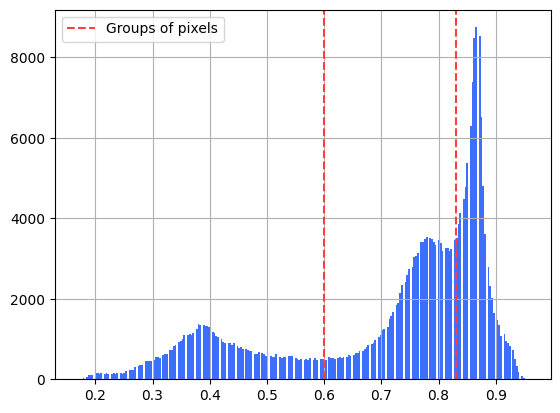

In [2]:
image_2 = np.copy(image)

# Histogram of the image
plt.hist(image_2.ravel(), bins=255, color=COLORS['BLUE'])

# Vertical lines
plt.axvline(x=0.6, linestyle='--', color=COLORS['RED'])
plt.axvline(x=0.83, linestyle='--', color=COLORS['RED'])

# Adding legend
red_legend = plt.Line2D([0], [0], color=COLORS['RED'], linestyle='--', label='Groups of pixels')
plt.legend(handles=[red_legend])

plt.grid()  
plt.show()

The first group below 0.6 represents black pixels and therefore bacteria, the group between 0.6 and 0.83 grey pixels and above 0.83 white pixels. So how to easily extract bacteria in the image?

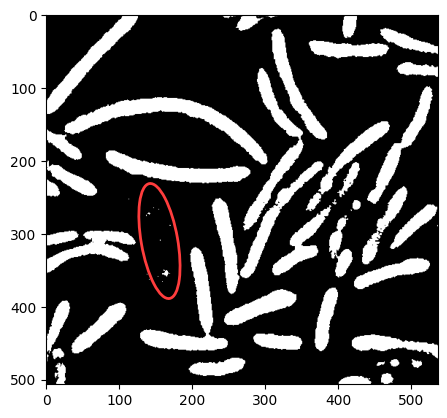

In [3]:
# Here bacteria is a binary mask of the image (so it's a 2D array of True/False values)
bacteria_mask = image < 0.6

# We can represent it as a grayscale image, where True is 1 and False is 0
plt.imshow(bacteria_mask, cmap='gray')

# We add an ellipse to the plot to show the principal artifacts of the image
ellipse = patches.Ellipse((155, 310), 2 * 80, 2 * 25, angle=80, edgecolor=COLORS['RED'], linewidth=2, facecolor='none')
plt.gca().add_patch(ellipse)

plt.show()

Not bad at all! The bacteria are clearly visible, but there are still a few **<span style="color:#FF3D3D">artifacts</span>**. We could stop there, but we can use the module `scipy` and more precisely the submodule [`scipy.ndimage`](https://docs.scipy.org/doc/scipy/reference/ndimage.html) to remove them. `scipy.ndimage` is a library that provides a collection of functions for multidimensional image processing. It is particularly useful for tasks such as image filtering, interpolation, morphology, measurements, and in our case, smoothing out the contours and removing **<span style="color:#FF3D3D">artifacts</span>**.


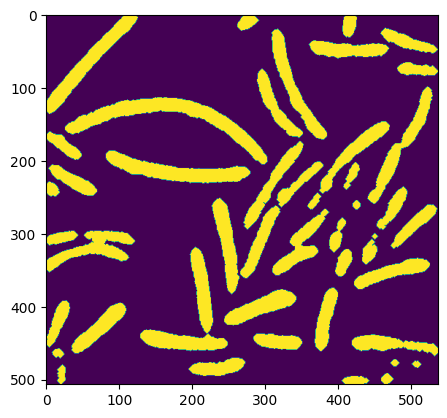

In [4]:
import scipy.ndimage as ndi

bacteria = ndi.binary_opening(bacteria_mask, iterations=4)

plt.imshow(bacteria)

Nice, the result is convincing (even if we split some existing bacteria because they had a white part within it)

<details class="alert alert-warning">
    <summary markdown="span"><b>Click to have more info about binary_opening</b></summary>
    <br>
    <a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.binary_opening.html" target="_blank">scipy.ndimage.binary_opening</a> is a function provided by the SciPy library in the ndimage module. This function is designed for binary image processing, specifically for morphological operations. Morphological operations involve the manipulation of the structure of an image, usually through the use of binary masks or structuring elements; it is commonly used to remove small objects and smooth the boundaries of larger objects in a binary image.
    <br><br> 
    <div style="display: flex; justify-content: space-between">
        <!-- Erosion Section -->
        <div style="flex: 1; text-align: center;">
            <h3>Erosion</h3>
            <p>The function first performs an <b>erosion</b> on the image that shrinks or erodes the boundaries of foreground objects (white regions) in a binary image. The basic idea is to slide a structuring element (also binary) over the input image, and for each position of the structuring element, if all the pixels underneath it are white (1), the corresponding pixel in the output image remains white; otherwise, it becomes black (0)</p>
            <img src="img/erosion.gif" alt="Erosion GIF" width="400"/>
            <p style="text-align: center;"><a href="https://pub.towardsai.net/introduction-to-image-processing-with-python-b3a85fd26734">Erosion</a></p>
        </div>
        <!-- Dilatation Section -->
        <div style="flex: 1; text-align: center;">
            <h3>Dilatation</h3>
            <p>The function then performs a <b>dilatation</b>, it expands or dilates the boundaries of foreground objects in a binary image. Similar to erosion, a structuring element is used, and for each position of the structuring element, if at least one pixel underneath it is white, the corresponding pixel in the output image becomes white; otherwise, it remains black.</p>
            <img src="img/dilatation.gif" alt="Dilatation GIF" width="400"/>
            <p style="text-align: center;"><a href="https://pub.towardsai.net/introduction-to-image-processing-with-python-b3a85fd26734">Dilatation</a></p>
        </div>
    </div>
</details>

We can now count the number of bacteria on the image thanks again to ndimage which has fantastic tools to do so:

Number of labels: 47


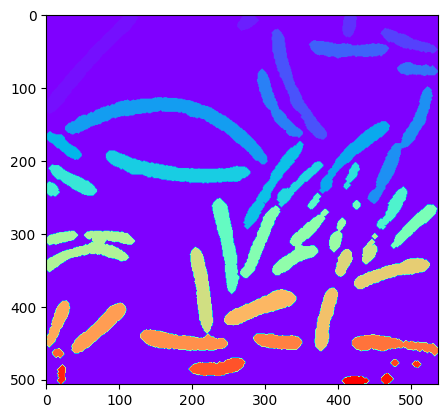

In [5]:
labels, n_labels = ndi.label(bacteria)
print(f"Number of labels: {n_labels}")

plt.imshow(labels, cmap='rainbow')

The result is very coherent, and all this without the application of any machine-learning techniques, just "simple" image processing. Here's a function (in utilities.py) that summarizes everything we've done and can be used on any image you like (e.g. the one in img_test/):

In [6]:
from utilities import compute_number_of_cells

# compute_number_of_cells('img_test/bacteria1.jpg', 0.6, 0.9)
# compute_number_of_cells('img_test/bacteria2.jpeg', 0.0, 0.3)

<details class="alert alert-warning">
    <summary markdown="span"><b>Process limitation</b></summary>
    <br>
    If you've tested the functions, you've probably realized that they don't work very well for images in img_test/. In fact, the processing we've carried out is very well suited to images with high contrasts, and therefore performs poorly for images that are a little messier, such as bacteria1.jpg and bacteria2.jpeg. Sooo, we need to find a better solution to analyse our more complex image and obtain a better semantic segmentation...
</details>



## Part 2: CNN and Convolution reminder

If I talk to you about image analysis, one word should immediately come to mind: convolution. Indeed, deep-learning networks using such layers are often extremely powerful in computer vision tasks, in other words, for analyzing, constructing and transforming images.

There are, for example, convolutional neural networks (or [`CNN`](https://datascientest.com/en/convolutional-neural-network-everything-you-need-to-know), you can also see the Isae's course about vision and its introduction to CNNs), which are mainly used for detecting objects in an image, and which no longer have to prove their effectiveness. There are mainly two parts in a CNN for detecting objects:

1. **_Convolutional Part_**: Its ultimate goal is to extract specific features from each image by compressing them to reduce their initial size. In summary, the input image goes through a series of filters, creating new images called convolution maps. Finally, the obtained convolution maps are concatenated into a feature vector called the CNN code.

2. **_Classification Part_**: The CNN code obtained as the output of the convolutional part is fed into a second part, consisting of fully connected layers called a Multi-Layer Perceptron (MLP). The role of this part is to combine the features of the CNN code to classify the image.

<div style="text-align:center;">
  <img src="img/cnn_working.png" alt="Image 1" width="800"/>

  [Source](https://fr.mathworks.com/videos/introduction-to-deep-learning-what-are-convolutional-neural-networks--1489512765771.html)
</div>



<details class="alert alert-warning">
    <summary markdown="span"><b>Reminder convolution, pooling...</b></summary>
    <br>
    As you can see from the image, there are several parts to the hidden layers. Normally there are no strange names, as we've seen them in our deep-learning courses, but here's a quick summary just in case: <br><br>
    <i>- What is a convolution?</i> 
    <br>
    The convolution layer is the core building block of the CNN. It carries the main portion of the network’s computational load.
    This layer performs a dot product between two matrices, where one matrix is the set of learnable parameters otherwise known as a kernel, and the other matrix is the restricted portion of the receptive field. The kernel is spatially smaller than an image but is more in-depth. This means that, if the image is composed of three (RGB) channels, the kernel height and width will be spatially small, but the depth extends up to all three channels. Here is a gif to have a better visualization:
    <br><br>
<div style="text-align:center;">
  <img src="img/convolution_gif.gif" alt="Image 1" width="400"/>

  [Source](https://fr.mathworks.com/videos/introduction-to-deep-learning-what-are-convolutional-neural-networks--1489512765771.html)
</div>
    <br><br>
    <i>- What is a pooling?</i>
    <br>
    The pooling layer replaces the output of the network at certain locations by deriving a summary statistic of the nearby outputs. This helps in reducing the spatial size of the representation, which decreases the required amount of computation and weights. There are several pooling functions such as the average of the rectangular neighborhood, L2 norm of the rectangular neighborhood, and a weighted average based on the distance from the central pixel. However, the most popular process is max pooling, which reports the maximum output from the neighborhood.
    <br><br>
<div style="text-align:center;">
  <img src="img/max_pooling.png" alt="Image 1" width="400"/>

  [Source](https://www.google.com/url?sa=i&url=https%3A%2F%2Fpaperswithcode.com%2Fmethod%2Fmax-pooling&psig=AOvVaw2Ea5_U0q6XjKl6Dl4D8G_h&ust=1706455601289000&source=images&cd=vfe&opi=89978449&ved=0CBQQjhxqFwoTCMjexNLw_YMDFQAAAAAdAAAAABAD )
</div>
    <br><br>
    <i>- Most common activation function</i>
    <br><br> 
    <div style="display: flex; justify-content: space-between">
        <div style="flex: 1; text-align: center;">
            <h3>Sigmoid</h3>
            <p>Sigmoid takes a real-valued number and “squashes” it into a range between 0 and 1. However, a very undesirable property of sigmoid is that when the activation is at either tail, the gradient becomes almost zero. If the local gradient becomes very small, then in backpropagation it will effectively “kill” the gradient. Also, if the data coming into the neuron is always positive, then the output of sigmoid will be either all positives or all negative.</p>
            <img src="img/sigmoid_function.png" alt="Sigmoid" width="400"/>
        </div>
        <div style="flex: 1; text-align: center;">
            <h3>ReLU</h3>
            <p>The Rectified Linear Unit (ReLU) has become very popular in the last few years. It computes the function ƒ(κ)=max (0,κ). In other words, the activation is simply threshold at zero. Unfortunately, a con is that ReLU can be fragile during training. A large gradient flowing through it can update it in such a way that the neuron will never get further updated. However, we can work with this by setting a proper learning rate.</p><br><br>
            <img src="img/relu_function.png" alt="ReLu" width="400"/>
        </div>
    </div>
</details>

Below is an example of a simple imprementation of a CNN in Pytorch that can performs object detection on image of size 28*28 in grayscale (only one chanel), with 10 labels (for example the first ten digits 0, ..., 9):

In [7]:
# !pip install torchviz
# !sudo apt-get install graphviz

<details class="alert alert-warning">
    <summary markdown="span"><b>Reminder dimension</b></summary>
    <br>
    I remind you that for an input_dim, the output_dim after a:<br>
    - <i>convolutional layer</i> will be output_size = [(input_dim − kernel_size + 2 * padding) / stride] + 1
    <br>
    - <i>max pooling layer</i> will be output_size = (input_size-kernel_size)/stride + 1
</details>



In [2]:
# First some essential imports 
import torch
import torch.nn as nn
import torch.optim as optim

from torchviz import make_dot

# Then we create a class that will define our CNN model
class SimpleCNN(nn.Module): # We inherit from nn.Module ie. the base class for all neural network modules
    def __init__(self):
        # We call the constructor of the parent class via super() (the init of nn.Module)
        super(SimpleCNN, self).__init__()


        ### CONVOLUTIONAL PART ###
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3,3))
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3,3))
        self.relu2 = nn.ReLU()
        
        # Max pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Flatten layer
        self.flatten = nn.Flatten()


        ### CLASSIFICATION PART ###
        # Fully connected layers
        self.fc1 = nn.Linear(32 * 12 * 12, 128)
        self.fc2 = nn.Linear(128, 10)
    
    # We define the forward pass of the network
    def forward(self, x):
        print(f"Initial shape: {x.shape}")
        # input 1*28*28, output 16*26*26
        x = self.relu1(self.conv1(x))
        print(f"Shape after first convolutional layer: {x.shape}")

        # input 16*26*26, output 32*24*24
        x = self.relu2(self.conv2(x))
        print(f"Shape after second convolutional layer: {x.shape}")

        # input 32*24*24, output 32*12*12
        x = self.pool(x)
        print(f"Shape after pooling layer: {x.shape}")

        # input 32*12*12, output 4608
        x = self.flatten(x)
        print(f"Shape after flattening: {x.shape}")

        # input 4608, output 128
        x = self.fc1(x)
        print(f"Shape after first fully connected layer: {x.shape}")

        # input 128, output 10
        x = self.fc2(x)
        print(f"Shape after second fully connected layer: {x.shape}")

        return x
    
# Instantiate the model
model = SimpleCNN()

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Create a dummy input to have an image to visualize
dummy_input = torch.randn(1, 1, 28, 28)
output = model(dummy_input)
dot = make_dot(output, params=dict(model.named_parameters()))
dot.render('./img/simple_cnn_model', format='png', cleanup=True)

Initial shape: torch.Size([1, 1, 28, 28])
Shape after first convolutional layer: torch.Size([1, 16, 26, 26])
Shape after second convolutional layer: torch.Size([1, 32, 24, 24])
Shape after pooling layer: torch.Size([1, 32, 12, 12])
Shape after flattening: torch.Size([1, 4608])
Shape after first fully connected layer: torch.Size([1, 128])
Shape after second fully connected layer: torch.Size([1, 10])


'img/simple_cnn_model.png'

I also used the module torchviz to perform a visualization of our network:

<div style="text-align:center;">
  <img src="img/simple_cnn_model.png" alt="Image 1" height="500"/>
</div>

So now you remember how to build a simple CNN capable of performing object detection tasks with a high success rate. Well done! Additionnaly i can give you [`this`](https://poloclub.github.io/cnn-explainer/) to have a better visualisation of what's going on in a CNN network. 

## Part 3: U-net, a solution to semantic segmantation

### How it works?

But let's get back to business: the aim of this BE is not object detection, but rather sementic segmentation, i.e. obtaining the detailed contours of objects in an image like that: 

<div style="text-align:center;">
  <img src="img/semantic_fruits.png" alt="Image 1" height="300"/>

  [Source](https://www.v7labs.com/blog/semantic-segmentation-guide)
</div>

As we've seen, in most cases, CNN has a fully connected layer at the end in order to make class label predictions. But, in semantic segmentation tasks, a fully connected layer at the end is typically unnecessary, as our objective is not to predict the image's class label. Instead, the goal is to extract features for segmenting the image into distinct regions.

Despite the benefits of convolutional networks, they tend to reduce image size due to max-pooling layers. To effectively segment the image, we employ upsampling through interpolation techniques, facilitated by deconvolutional layers. This process ensures the preservation of spatial information and aids in the accurate separation of the image into multiple segments.

In the broader context of artificial intelligence terminology, the convolutional network responsible for feature extraction is commonly referred to as an <span style="color:#1547FF">encoder</span> (below it is the left part). This <span style="color:#1547FF">encoder</span> not only extracts features but also reduces the size of the image through <span style="color:#1547FF">downsampling</span>. On the other hand, the convolutional network utilized for the <span style="color:#FF2828">upsampling</span> process is known as a <span style="color:#FF2828">decoder</span> (below it is the right part). Here is an image to sum up the process:

<div style="text-align:center;">
  <img src="img/convolutional_encoder_decoder.png" alt="Image 1" width="900"/>

  [Source](https://www.researchgate.net/figure/13-convolutional-layers-encoder-decoder-network-architecture-The-net-allows-for-a_fig1_325966644)
</div>

The output yielded by the decoder is rough, because of the information lost at the final convolution layer i.e., the 1 X 1 convolutional network. This makes it very difficult for the network to do upsampling by using this little information. So this clearly isn't the best architecture to perform semantic segmentation. Do you have any ideas on how to improve the structure to retain more information during upsampling?

You have to "pass" information directly from the encoder to the decoder. To do this, you need **_"bridges"_** or **_"shortcuts"_** between the two parts. And it's this simple idea behind U_NET that's revolutionizing everything! These **_shortcuts_** are designed to tackle the information loss problem. Here's a visualization of how the network works, taken directly from the [`founding paper`](https://arxiv.org/pdf/1505.04597.pdf) by [`Olaf Ronneberger`](https://scholar.google.de/citations?user=7jrO1NwAAAAJ&hl=de), [`Philipp Fischer`](https://scholar.google.com/citations?user=M2j8KYMAAAAJ&hl=en), and [`Thomas Brox`](https://scholar.google.com/citations?user=0VAe-TQAAAAJ&hl=de):

<div style="text-align:center;">
  <img src="img/U_net_visualization.png" alt="Image 1" width="700"/>

  [Source](https://arxiv.org/pdf/1505.04597.pdf)
</div>

Here on the image, the direct <span style="color:grey">bridges</span> between encoder and decoder are visible in <span style="color:grey">grey</span>. They enable a much more faithful reconstruction of the image during the upsampling phase. In the upsampling part they have also a large number of feature channels, which allow the network to propagate context information to higher resolution layers. As a consequence, the expansive path (decoder) is more or less symmetric to the contracting path (encoder), and yields a u-shaped architecture because of the almost perfect symmetry between the encoder and decoder:

<div style="text-align:center;">
  <img src="img/unet_viz.png" alt="Image 1" width="700"/>

  [Source](https://www.youtube.com/watch?v=NhdzGfB1q74)
</div>

Apart from these bridges and the unusual symmetry, the structure is quite simple, consisting of the layers we saw in part 2: It has a <span style="color:#1547FF">contracting path (left side)</span> and an <span style="color:#FF2828">expansive path (right side)</span>.
<br>
- **_<span style="color:#1547FF"> The contracting path</span>_** adheres to the conventional architecture, featuring the repetitive application of two 3x3 convolutions (unpadded), each succeeded by a rectified linear unit (ReLU), and a 2x2 max-pooling operation with a stride of 2 for downsampling. With each downsampling step, there is a doubling of the number of feature channels.
<br><br>
- **_<span style="color:#FF2828">The expansive path</span>_** comprises an upsampling of the feature map, succeeded by a 2x2 convolution ("up-convolution") that reduces the number of feature channels by half. This is followed by concatenation with the correspondingly cropped feature map from the contracting path, and two 3x3 convolutions, each followed by a ReLU. The necessity of cropping arises due to the loss of border pixels in each convolution.

At the final layer, a 1x1 convolution is employed to map each 64-component feature vector to the desired number of classes. The entire network encompasses a total of 23 convolutional layers.

Here is a [`french page`](https://blent.ai/blog/a/unet-computer-vision) or [`another one`](https://datascientest.com/u-net) or an [`english video`](https://www.youtube.com/watch?v=NhdzGfB1q74) that sum-up what was said.

### Let's code it!

You now have all the knowledge you need to code your own U-net network, so I'll remind you of the architecture below:
<div style="text-align:center;">
  <img src="img/U_net_visualization.png" alt="Image 1" width="700"/>

  [Source](https://arxiv.org/pdf/1505.04597.pdf)
</div

<details class="alert alert-warning">
    <summary markdown="span"><b>Reminder dimension (again)</b></summary>
    <br>
    I remind you that for an input_dim, the output_dim after a:<br>
    - <i>convolutional layer</i> will be output_size = [(input_dim − kernel_size + 2 * padding) / stride] + 1
    <br>
    - <i>max pooling layer</i> will be output_size = input_size/2
    <br><br>
    <i>For example:</i><br>
        - Input: (3,572,572) <br>
        - Conv Kernel: (3, 3), channel=64, padding=0, stride=1<br>
        - Output: (64,(572-3+2*0+1),(572-3+2*0+1)) = (64,570,570)<br>
</details>

The kernel for convolutional layers has a size of **(3, 3)** with a padding of **1**. 

The original UNET does not use batch normalization in between the convolution layer and ReLU. Here we insert batch normalization in between them. It helps the network to reduces internal covariance shift and makes the network more stable while training.

We first define a convolutional block (because it will be the same for all part, just the input and output dimensions will change):

<div style="background-color: #FF2828; padding: 10px;">
    <div style="color: #8D1313; font-size: 15;"><b>Here you code!</b></div>
</div>

In [ ]:
class conv_block(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(conv_block, self).__init__()

        # Your code here for first convolutional layer
        self.bn1 = nn.BatchNorm2d(out_channels)
        # Your code here for second convolutional layer
        self.bn2 = nn.BatchNorm2d(out_channels)
        # Your code here for the activation function
        
    def forward(self, x):
        # Your code here
        return x

In [1]:
# %load solutions/sol_conv_block.py

We will now code **_<span style="color:#1547FF"> the contracting path ie. the encoder</span>_**. To do that we'll use the convolutionnal block we've just defined before followed by a max_pooling. Don't forget the result from both convolutionnal layer (so before the max pooling) will be used in **_<span style="color:#FF2828">the expansive path ie. the decoder</span>_** so please return also an intermediate output (called **_x_**) to use it after.

In [ ]:
class encoder(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(encoder, self).__init__()

        # We use the conv_block we've defined in the previous snippet
        # Your code here for the first convolutional block
        
        # Your code here for the second max pooling layer
        
    def forward(self, x):
        # Your code here

        # Here p is the output of both convolutional layers before max pooling
        return x, p

In [2]:
# %load solutions/sol_encoder.py

Finally, we will code **_<span style="color:#FF2828">the expansive path ie. the decoder</span>_**. To upsample the image you can use the [`ConvTranspose2d`](https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html) with a kernel_size of 2 and a stride of 2. Also the intermediate **_x_** returned by the encoder will be used in the forward pass (it is called **_skip_** in the function) and represent the **_bridges_** between  **_<span style="color:#1547FF">the encoder</span>_** and **_<span style="color:#FF2828">the decoder</span>_**, so you need to concanate ([`torch.cat`](https://pytorch.org/docs/stable/generated/torch.cat.html)) it to the result of the upsampling.

In [11]:
class decoder(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(decoder, self).__init__()
        
        # Here the upsampling is done by a transposed convolution
        # Your code here

        # Here we apply the conv_block we've defined in the previous snippet (think about dimensions)
        # Your code here
        
    def forward(self, inputs, skip):
        # Your code here

        # Here we concatenate the output of the upsampling with the output of the encoder at the same level
        # Your code here

        # Your code heress
        
        return x

In [5]:
# %load solutions/sol_decoder.py

Now all you have to do is assemble the blocks coded in the preceding snippets into a single U-net network. I'll remind you for the last time of the network structure so that you have the dimensions in mind:

<div style="text-align:center;">
  <img src="img/U_net_visualization.png" alt="Image 1" width="700"/>

  [Source](https://arxiv.org/pdf/1505.04597.pdf)
</div

In [16]:
class Unet(nn.Module):
    def __init__(self, num_classes):
        super(Unet, self).__init__()

        """ Encoder """
        self.e1 = encoder(3, 64)
        self.e2 = # Your code here
        self.e3 = # Your code here
        self.e4 = # Your code here

        """ Bottleneck """
        self.bott = # Your code here

        """ Decoder """
        self.d1 = decoder(1024, 512)
        self.d2 = # Your code here
        self.d3 = # Your code here
        self.d4 = # Your code here

        """ Classifier """
        self.outputs = nn.Conv2d(64, num_classes, kernel_size=1, padding=0)

    def forward(self, x):
        
        """ Encoder """
        s1, p1 = self.e1(x)
        s2, p2 = # Your code here
        s3, p3 = # Your code here
        s4, p4 = # Your code here

        """ Bottleneck """
        b = self.bott(p4)

        """ Decoder """
        d1 = self.d1(b, s4)
        d2 = # Your code here
        d3 = # Your code here
        d4 = # Your code here
        
        """ Classifier """
        outputs = self.outputs(d4)

        return outputs

In [ ]:
# %load solutions/sol_unet.py

Well done! You've just coded a complete U-net neural network! Now all that's left is to train and test it. I tried to train the model on my own, but couldn't finish because it was taking so long. Next, we'll use a pre-trained model available on [`github`](https://github.com/milesial/Pytorch-UNet?tab=readme-ov-file). This model has been trained for clipping cars for a [`kaggle challenge`](https://www.kaggle.com/c/carvana-image-masking-challenge): Carvana Image Masking Challenge. You can see some of these images in the car_test folder. 

But before, I'll quickly explain how to train the model. You must know that in deep neural networks featuring numerous convolutional layers and diverse pathways, the initialization of weights holds utmost importance. Without proper initialization, certain segments of the network may become overly active, while others remain largely dormant. In the case of our architecture, characterized by alternating convolutional and ReLU layers, this can be accomplished by drawing initial weights from a Gaussian distribution with a standard deviation of p √(2/N), where N represents the number of incoming nodes for each neuron. For instance, in a scenario involving a **_3x3_** convolution and **_64_** feature channels in the preceding layer, N would equate to **_9_** multiplied by **_64_**, yielding a value of **_576_**.

To test U-net let's first import the model (the 1.0 is more precise but it's up to you to chose the one you want)

In [4]:
model_to_download_scale_1_0 = "https://github.com/milesial/Pytorch-UNet/releases/download/v3.0/unet_carvana_scale1.0_epoch2.pth"
model_to_download_scale_0_5 = "https://github.com/milesial/Pytorch-UNet/releases/download/v3.0/unet_carvana_scale0.5_epoch2.pth"

download_folder = "./models"

In [5]:
!wget -q -N -P {download_folder} {model_to_download_scale_1_0}
# !wget -q -N -P {download_folder} {model_to_download_scale_0_5}

I then coded a small utility function that calls the template and runs the process on an image (all the result will be in return_predictions folder):

In [2]:
from utilities import predict

### RUN FOR A SINGLE IMAGE (YOU CAN CHOSE) ###
# predict('car_1.jpg', folder='car_test', scale=1.0, verbose= False)

### RUN FOR MULTIPLE IMAGES (YOU CAN CHOSE) ###
for i in range(1, 30, 2):
    predict(f'car_{i}.jpg', folder='car_test', scale=1.0, verbose=False)

### RUN FOR ALL IMAGES IN THE FOLDER ###
# predict('ALL', folder='car_test', scale=1.0, verbose=False)

I have also coded a way to merge original and prediction into one photo for displaying purpose, they are stored in merged_images folder

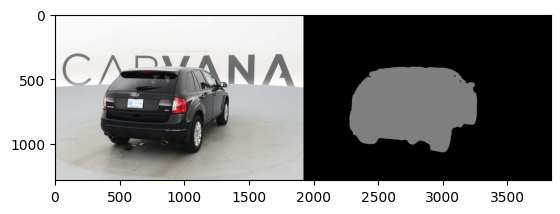

In [1]:
# !pip install Pillow

from utilities import merge_all_images, print_images_in_folder

merge_all_images()

print_images_in_folder('merged_images')

### A small word about data augmentation